# EMBED ROIs
### Beatrice Brown-Mulry

---
## Contents:
- **0. Overview**
- **1. Usage**
- **2. Example Patch Workflow**

---
# 0. Overview

# EMBED ROIs
## Overview
ROIs in EMBED were collected by mapping screensave images (generated when any
annotations are made by a radiologist) to their original source images. During this process, ROIs
were mapped back to both the original image (**a primary match**) and its corresponding C-View
or 2D image (**a secondary match**).

![roi_matching](images/roi_matching.png)

The original elliptical annotations were mapped to rectangles and their corner points were used to record the ROIs. Each ROI is given in the form *[ymin, xmin, ymax, xmax]*.
![roi_overview](images/roi_overview.png)

ROIs are nested to allow multiple to be assigned to a single image.
![roi_nesting](images/roi_nesting.png)

---
# 1. Usage

In [ ]:
import pandas as pd
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import cv2 as cv

# these let us set the number of rows/cols of our dataframes we want to see
# EMBED has a lot of columns so it's a good idea to increase this from the default
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)

In [ ]:
def plot_rois(ax, roi_list: list, match_level_list: list):
    """
    function to plot the rois on the given matplotlib axes
    """
    # set our dicts to color primary/secondary ROIs differently
    color_dict = {1: 'xkcd:bright green', 2: 'xkcd:bright red'}
    label_dict = {1: 'Primary ROI', 2: 'Secondary ROI'}
    
    # zip the rois and their match levels together
    for roi, match_level in zip(roi_list, match_level_list):
        # unpack our ROI values
        ymin, xmin, ymax, xmax = roi
        
        # format the roi into a patch
        roi_patch = pat.Rectangle(
            (xmax, ymax),
            xmin - xmax,
            ymin - ymax,
            edgecolor=color_dict[match_level], 
            fc='None', 
            label=label_dict[match_level]
        )
        
        # add the patch to the axes
        ax.add_patch(roi_patch)
        
def plot_image(image, roi_list: list, match_level_list: list, title: str or None = None):
    """
    function to take a cv2 image and a list of rois and match levels
    and plot them
    """
    # get a figure and axis
    fig, ax = plt.subplots(1, 1, dpi=150)

    if title is not None:
        ax.set_title(title)
    
    # plot our image on the axes
    ax.imshow(image, cmap='gray')
    
    # plot our rois on the axes
    plot_rois(ax, roi_list, match_level_list)
    
    # get a legend
    ax.legend()
    
    # show the image
    fig.show()

    
def parse_roi(roi_coords: str):
    """
    function to convert our ROI_coords string into a nested list.
    since we don't care about mapping back to the original ROI_SSC image 
    we can discard one level of nesting to make it easier to use
    """
    # remove "][)(," symbols from the string
    roi_coords = roi_coords.translate({ord(c): None for c in "][)(,"})
    
    # split the list on whitespace, map each value to an 
    # integer, and send it to a list
    # we now have a list like this 
    # [ymin0, xmin0, ymax0, xmax0, ymin1, ...]
    flat_roi_list = list(map(int, roi_coords.split()))
    
    # we need to reformat it to 
    # [[ymin0, xmin0, ymax0, xmax0], [ymin1, ...]]
    # get an empty list
    out_roi_list = []
    
    # iterate over the number of rois (number of coords mod 4)
    for i in range(len(flat_roi_list) // 4):
        # for each, append the relevant 4 flat_roi_list 
        # indices to the out_roi_list
        out_roi_list.append(flat_roi_list[4*i:4*i+4])
        
    return out_roi_list

def parse_match_level(match_level: str):
    """
    function to convert our ROI_match_level string into a nested list.
    since we don't care about mapping back to the original ROI_SSC image 
    we can discard one level of nesting to make it easier to use
    """
    # remove "][' " symbols from the string
    match_level = match_level.translate({ord(c): None for c in "][',"})
    
    # split the list on commas, map each value to an integer
    # and sent it to a list
    match_level_list = list(map(int, match_level.split()))
    
    return match_level_list

In [4]:
# we'll load a pre-built dataset (the normal versus abnormal dataset from the data engineering notebook)
# to inspect some of the ROIs
scr_br0_meta = pd.read_csv('./datasets/POSITIVE_BR0_GROUP.csv')

scr_br0_meta.png_path = scr_br0_meta.png_path.str.replace('/data/mammo', '/fsx/embed/emory-mammo/images')
scr_br0_meta.anon_dicom_path = scr_br0_meta.anon_dicom_path.str.replace('/mnt/NAS2/mammo/anon_dicom', '/fsx/embed/emory-mammo/images/dicom')

# correct path for server
# scr_br0_meta.png_path = scr_br0_meta.png_path.str.replace('/ssd-data', '/mnt/NAS3')
# scr_br0_meta.anon_dicom_path = scr_br0_meta.anon_dicom_path.str.replace('/mnt/NAS2/mammo', '/mnt/NAS3/nas2-mammo')

> The metadata dataframe contains the column `num_roi` which can be used to filter images based on their ROI count.

In [5]:
scr_br0_meta.num_roi.value_counts(dropna=False)

num_roi
0.0     34374
1.0      7037
2.0      1210
3.0       169
4.0        44
5.0         6
10.0        5
6.0         3
Name: count, dtype: int64

In [6]:
# we'll filter our earlier dataframe to only include images with at least 1 ROI
roi_df = scr_br0_meta[scr_br0_meta.num_roi > 0]
roi_df

,empi_anon,acc_anon,study_date_anon_x,desc,side,asses,path_severity,bside,procdate_anon,pdate_anon,massshape,massmargin,massdens,calcdistri,calcfind,calcnumber,tissueden,ETHNICITY_DESC,ETHNIC_GROUP_DESC,MARITAL_STATUS_DESC,age_at_study,numfind,exam_laterality,ImageLateralityFinal,ViewPosition,study_date_anon_y,FinalImageType,png_path,anon_dicom_path,StudyDescription,ROI_match_level,num_roi,PNG_ROI_coords,DCM_ROI_coords,spot_mag
10,10023113,5135241747022662,2016-10-05,MG Screen Bilat w/Tomo/CAD Stnd Protocol,L,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,African American or Black,Non-Hispanic or Latino,Single,58.895118,1,B,L,MLO,2016-10-05,2D,/fsx/embed/emory-mammo/images/png/cohort_1/ext...,/fsx/embed/emory-mammo/images/dicom/cohort_1/1...,MG Screen Bilat w/Tomo/CAD Stnd Protocol,[['1']],1.0,"[[[352, 2, 990, 813]]]","[[[352, 2, 990, 813]]]",NaN
19,10044241,3993319361430024,2019-07-27,MG Screen Bilat w/Tomo/CAD Stnd Protocol,L,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G,0,2.0,African American or Black,Non-Hispanic or Latino,Widow(er),69.704374,1,B,L,CC,2019-07-27,2D,/fsx/embed/emory-mammo/images/png/cohort_1/ext...,/fsx/embed/emory-mammo/images/dicom/cohort_1/1...,MG Screen Bilat w/Tomo/CAD Stnd Protocol,[['1']],1.0,"[[[1561, 864, 3182, 1753]]]","[[[1561, 864, 3182, 1753]]]",NaN
20,10044241,3993319361430024,2019-07-27,MG Screen Bilat w/Tomo/CAD Stnd Protocol,L,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G,0,2.0,African American or Black,Non-Hispanic or Latino,Widow(er),69.704374,1,B,L,MLO,2019-07-27,2D,/fsx/embed/emory-mammo/images/png/cohort_1/ext...,/fsx/embed/emory-mammo/images/dicom/cohort_1/1...,MG Screen Bilat w/Tomo/CAD Stnd Protocol,[['1']],1.0,"[[[892, 298, 2319, 1477]]]","[[[892, 298, 2319, 1477]]]",NaN
27,10075593,6655844580865466,2020-06-09,MG Screen Bilat w/Tomo/CAD Stnd Protocol,L,A,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,0,3.0,Caucasian or White,Non-Hispanic or Latino,Married,73.099379,1,B,L,CC,2020-06-09,2D,/fsx/embed/emory-mammo/images/png/cohort_1/ext...,/fsx/embed/emory-mammo/images/dicom/cohort_1/1...,MG Screen Bilat w/Tomo/CAD Stnd Protocol,[['1']],1.0,"[[[1037, 0, 1550, 216]]]","[[[1037, 2344, 1550, 2560]]]",NaN
29,10075593,6655844580865466,2020-06-09,MG Screen Bilat w/Tomo/CAD Stnd Protocol,L,A,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,0,3.0,Caucasian or White,Non-Hispanic or Latino,Married,73.099379,1,B,L,CC,2020-06-09,2D,/fsx/embed/emory-mammo/images/png/cohort_1/ext...,/fsx/embed/emory-mammo/images/dicom/cohort_1/1...,MG Screen Bilat w/Tomo/CAD Stnd Protocol,[['1']],1.0,"[[[1189, 8, 1642, 433]]]","[[[1189, 2127, 1642, 2552]]]",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42821,99935792,7342511220486189,2019-02-20,MG Screen Bilat w/Tomo/CAD Stnd Protocol,R,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3.0,Caucasian or White,Hispanic or Latino,Not Recorded,37.736572,2,B,R,CC,2019-02-20,2D,/fsx/embed/emory-mammo/images/png/cohort_2/ext...,/fsx/embed/emory-mammo/images/dicom/cohort_2/9...,MG Screen Bilat w/Tomo/CAD Stnd Protocol,"[['1', '1']]",2.0,"[[[1736, 885, 2109, 1367], [2006, 143, 2261, 4...","[[[1736, 1961, 2109, 2443], [2006, 2928, 2261,...",NaN
42822,99935792,7342511220486189,2019-02-20,MG Screen Bilat w/Tomo/CAD Stnd Protocol,R,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3.0,Caucasian or White,Hispanic or Latino,Not Recorded,37.736572,2,B,R,MLO,2019-02-20,2D,/fsx/embed/emory-mammo/images/png/cohort_2/ext...,/fsx/embed/emory-mammo/images/dicom/cohort_2/9...,MG Screen Bilat w/Tomo/CAD Stnd Protocol,[['1']],1.0,"[[[725, 723, 1087, 1102]]]","[[[725, 2226, 1087, 2605]]]",NaN
42845,99991060,5463528102254256,2016-03-08,MG Screening Bilateral,R,A,4.0,R,2016-03-28,2016-03-29 00:00:00,G,NaN,NaN,NaN,NaN,0,2.0,Asian,Non-Hispanic or Latino,Married,46.771665,1,B,R,MLO,2016-03-08,2D,/fsx/embed/emory-mammo/images/png/cohort_10/ex...,/fsx/embed/emory-mammo/images/dicom/cohort_10/...,MG Screening Bilateral,"[['1', '1']]",2.0,"[[[1287, 889, 1517, 1104], [1

> ROI coordinates are stored in two columns `PNG_ROI_coords` and `DCM_ROI_coords`. The only difference between these two columns is the horizontal alignment of the ROI. During our PNG conversion process we applied logic to flip all images to face towards the right (with the chest wall on the left side), this flipping is not present on the original DICOMs, so the correct column should be used depending on the file format employed.

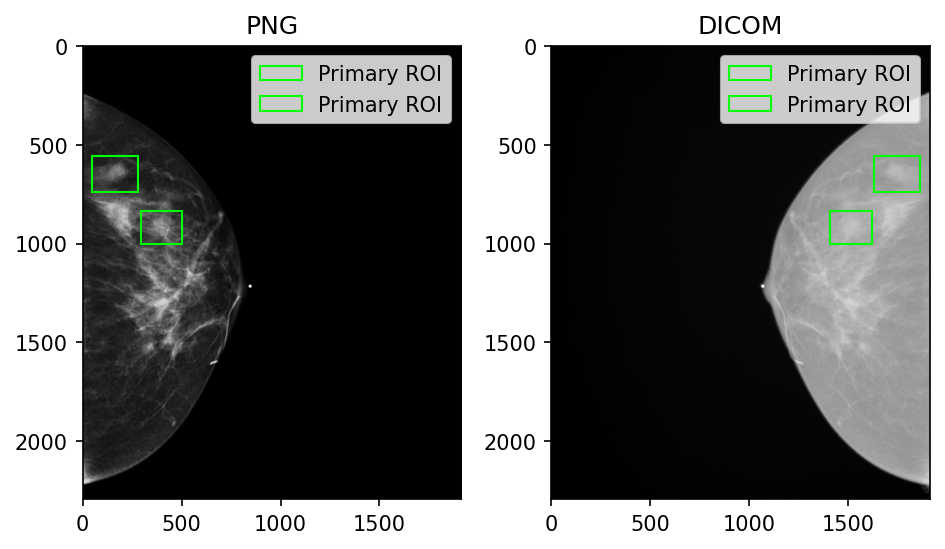

In [7]:
row = roi_df[roi_df.PNG_ROI_coords != roi_df.DCM_ROI_coords].sample(1)

# get a figure and axis
fig, ax_list = plt.subplots(1, 2, dpi=150)

# load images and assemble them into a dict
png_img = cv.imread(row.png_path.item())
dcm_img = pydicom.dcmread(row.anon_dicom_path.item()).pixel_array
img_dict = {'PNG': png_img, 'DICOM': dcm_img}

# parse match levels
match_level_list = parse_match_level(row.ROI_match_level.item())

# parse rois and assemble them into a dict
png_roi_list = parse_roi(row.PNG_ROI_coords.item())
dcm_roi_list = parse_roi(row.DCM_ROI_coords.item())
roi_dict = {'PNG': png_roi_list, 'DICOM': dcm_roi_list}

# plot images and their rois
for ax, title in zip(ax_list, ('PNG', 'DICOM')):
    ax.set_title(title)

    # plot our image on the axes
    ax.imshow(img_dict[title], cmap='gray')
    
    # plot our rois on the axes
    plot_rois(ax, roi_dict[title], match_level_list)
    
    # get a legend
    ax.legend()

# show the plot
fig.set_tight_layout(2)
fig.show()


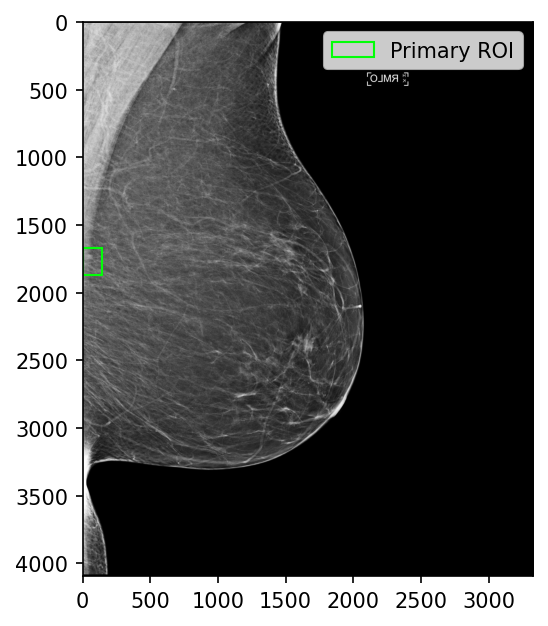

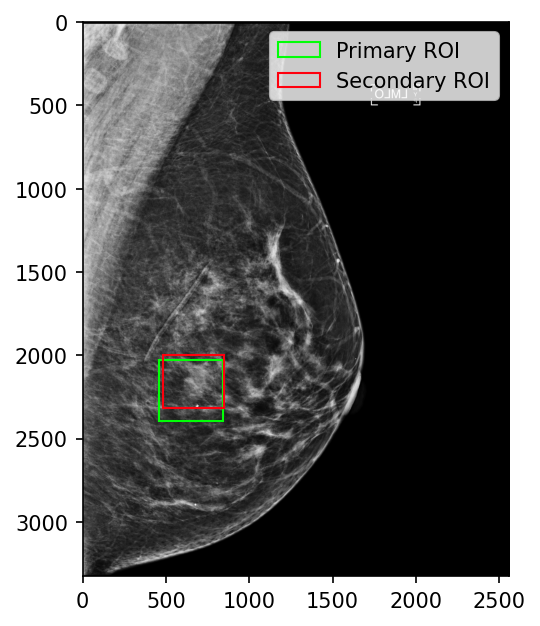

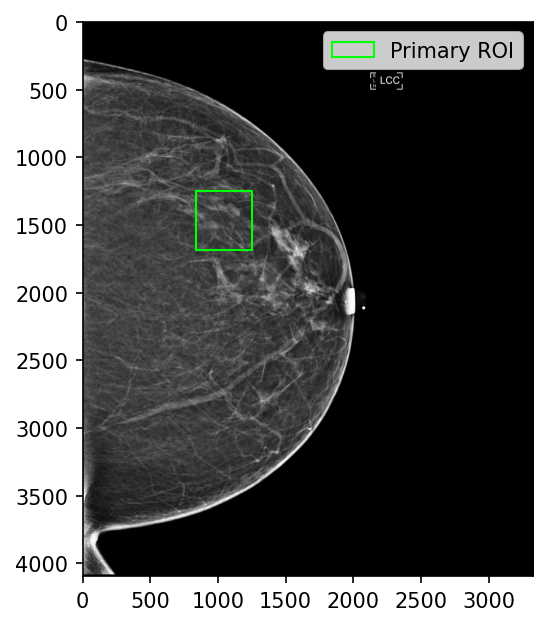

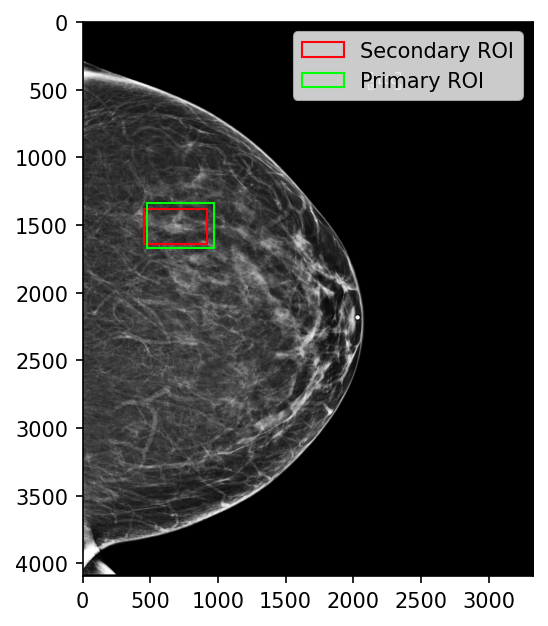

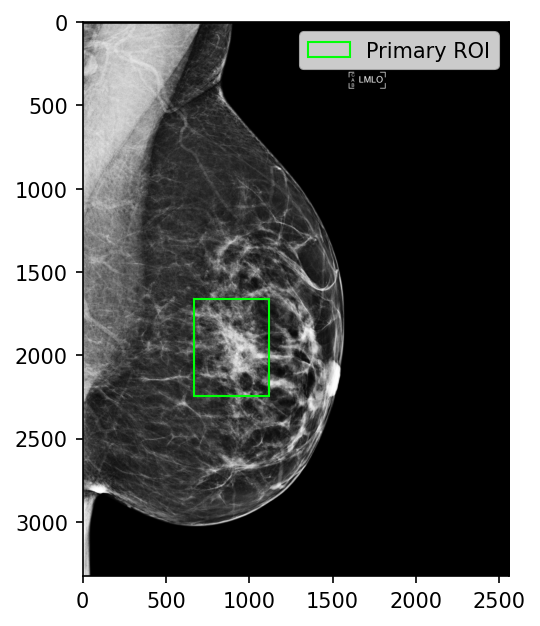

In [60]:
for i, row in roi_df.sample(5).iterrows():
    img = cv.imread(row.png_path)
    roi_list = parse_roi(row.PNG_ROI_coords)
    match_level_list = parse_match_level(row.ROI_match_level)
    plot_image(img, roi_list, match_level_list)

---
# 2. Example Patch Workflow

In [18]:
def prepare_patch(img, roi_list, tissue_pad: bool = True, patch_size: int = 512):
    # we'll just extract our first ROI from this list for the patch
    patch_roi = roi_list[0]

    if tissue_pad:
        patch = tissue_pad_patch(img, patch_roi, patch_size)
    else:
        patch = black_pad_patch(img, patch_roi, patch_size)

    # crop the ROI from the patch and tissue pad it
    return patch

def tissue_pad_patch(img, roi, patch_size):
    """
    function to tissue pad a patch given an image, a single ROI in the form [y_min, x_min, y_max, x_max]
    and the desired patch size
    """
    half_size = patch_size // 2
    
    # unpack roi
    y_min, x_min, y_max, x_max = roi
    
    # get the center y, x
    y_center = int((y_min + y_max)/2)
    x_center = int((x_min + x_max)/2)
    
    # get initial patch coords
    patch_y_min = y_center - half_size
    patch_x_min = x_center - half_size
    patch_y_max = y_center + half_size
    patch_x_max = x_center + half_size

    # correct the patch coords to make sure they fall within the image
    patch_y_max = max(min(patch_y_max, img.shape[0]), patch_size)
    patch_x_max = max(min(patch_x_max, img.shape[1]), patch_size)
    
    # ensure y_min is less than y_max - min_roi_size
    # and greater than 0
    patch_y_min = max(min(patch_y_min, patch_y_max - patch_size), 0)
    patch_x_min = max(min(patch_x_min, patch_x_max - patch_size), 0)

    return img[patch_y_min:patch_y_max, patch_x_min:patch_x_max, 0]
    

def black_pad_patch(img, roi, patch_size):
    """
    function to black pad a patch given an image, a single ROI in the form [y_min, x_min, y_max, x_max]
    and the desired patch size
    """
    half_size = patch_size // 2
    
    # unpack roi
    y_min, x_min, y_max, x_max = roi

    # initialize our patch as an empty array of zeros
    patch = np.zeros((512, 512), dtype=np.uint8)

    # we need to handle cases where the ROI is larger than the patch size
    # check if the height of the roi exceeds the patch size
    if ((y_max - y_min) > patch_size):
        # get the center coordinate
        y_center = int((y_max + y_min) / 2)
        # clip to the roi size
        y_min = y_center - half_size
        y_max = y_center + half_size
        
    # check if the width of the roi exceeds the patch size
    if ((x_max - x_min) > patch_size):
        # get the center coordinate
        x_center = int((x_max + x_min) / 2)
        # clip to the roi size
        x_min = x_center - half_size
        x_max = x_center + half_size

    # this gives us the offset between the patch edge and the roi so we can center it
    patch_height = y_max - y_min
    patch_width = x_max - x_min
    half_y_diff = (patch_size - patch_height) // 2
    half_x_diff = (patch_size - patch_width) // 2

    # extract the roi from our original image and center it on the black patch array
    patch[half_y_diff:half_y_diff+patch_height, half_x_diff:half_x_diff+patch_width] = img[y_min:y_max, x_min:x_max, 0]
    return patch

    

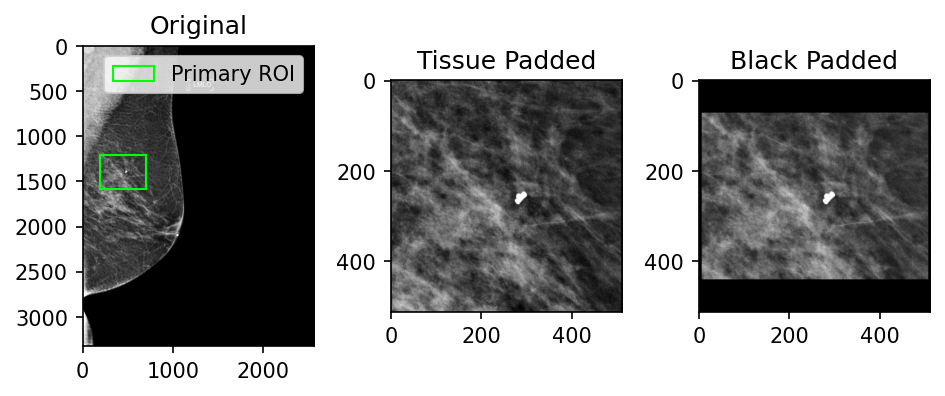

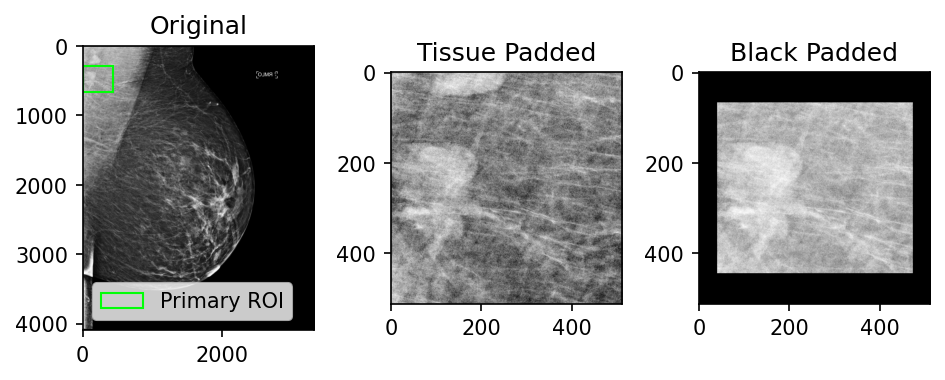

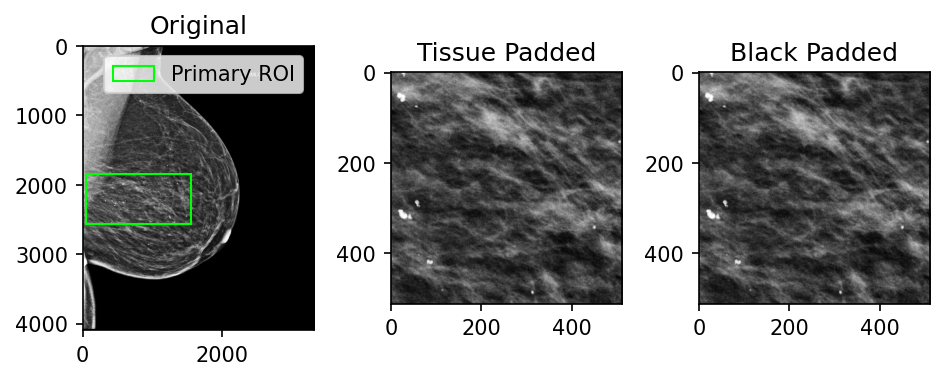

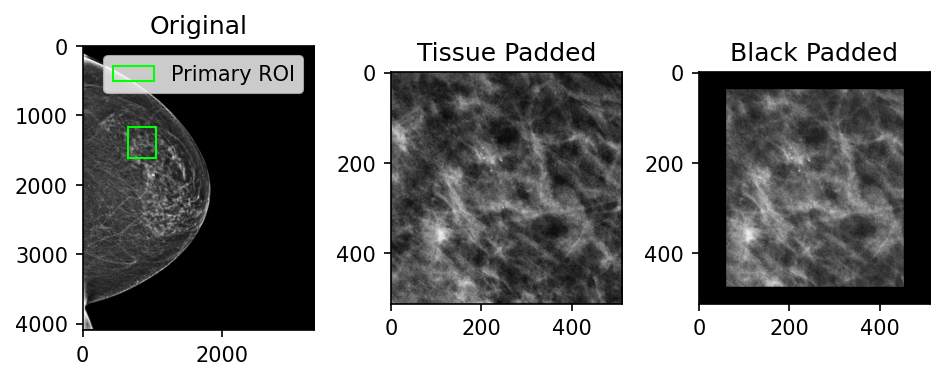

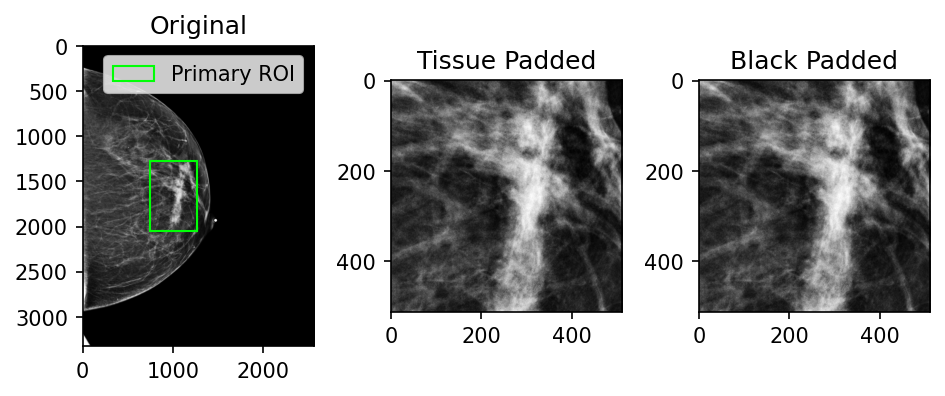

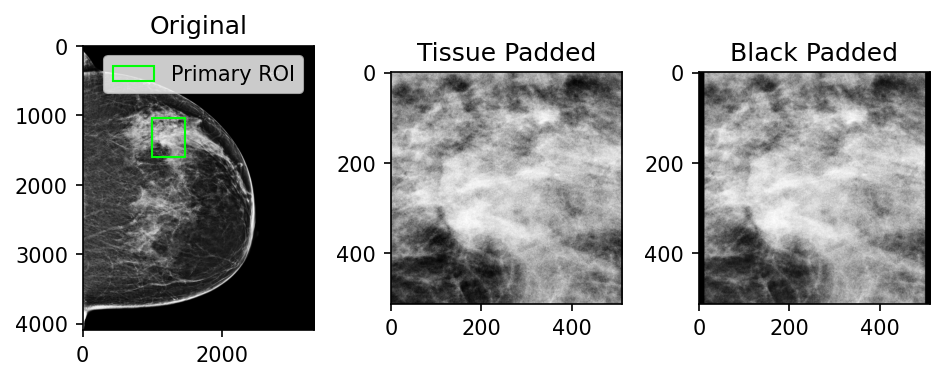

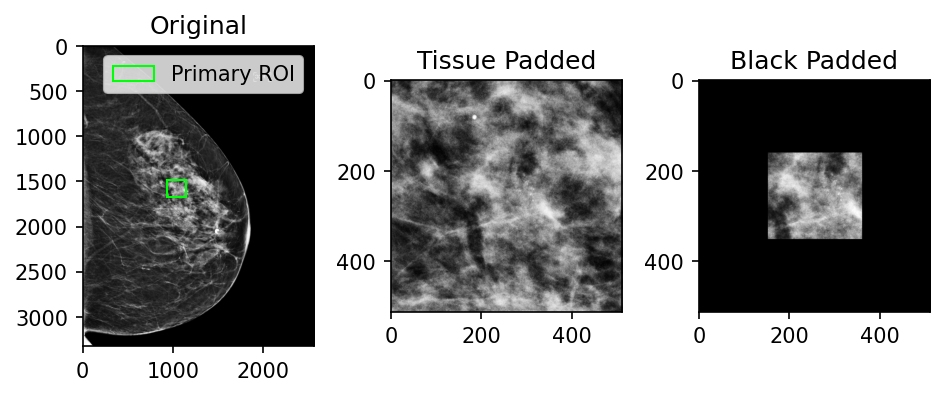

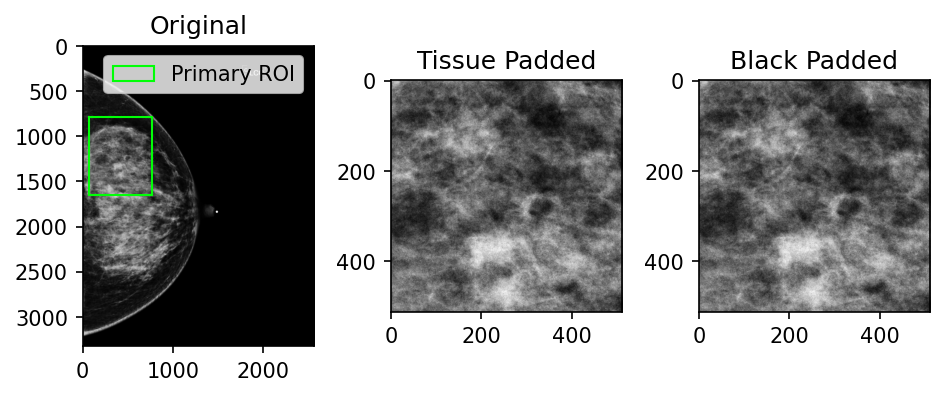

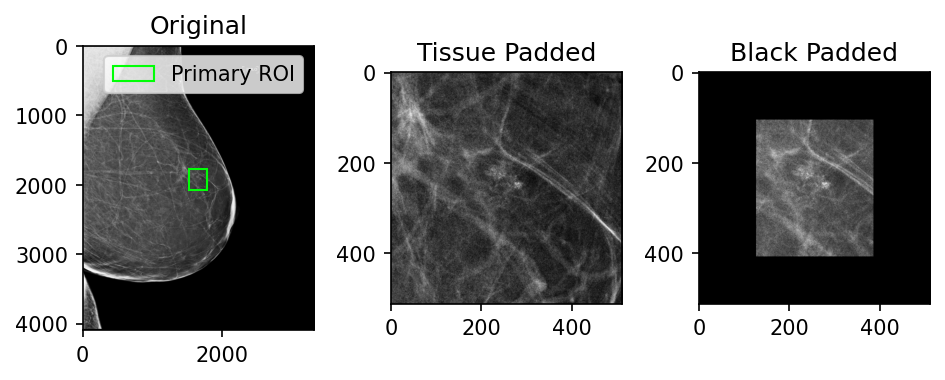

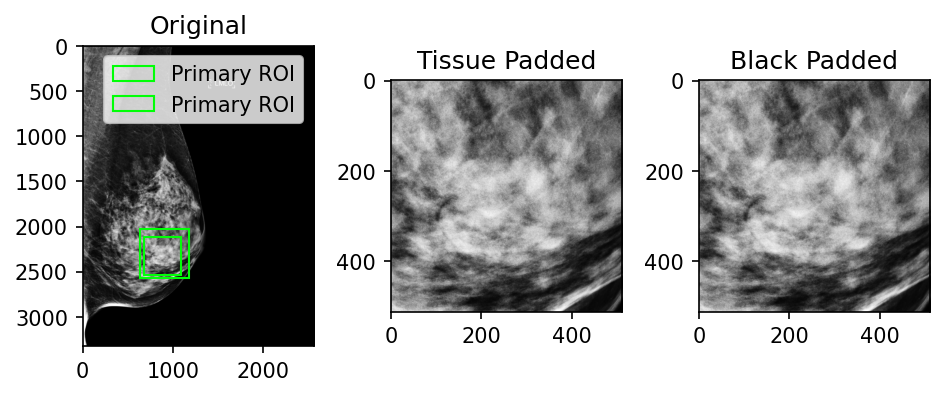

In [23]:
SEED = 76143

for i, row in roi_df.sample(10, random_state=SEED).iterrows():
    # get a figure and axis
    fig, ax_list = plt.subplots(1, 3, dpi=150)
    
    # load images and assemble them into a dict
    img = cv.imread(row.png_path)
    
    # parse match levels
    match_level_list = parse_match_level(row.ROI_match_level)
    
    # parse rois and assemble them into a dict
    # since we're loading from PNG we'll use the PNG_ROI_coords
    roi_list = parse_roi(row.PNG_ROI_coords)

    # plot the original image and rois on the first axes
    ax_list[0].set_title('Original')
    ax_list[0].imshow(img)
    plot_rois(ax_list[0], roi_list, match_level_list)
    ax_list[0].legend()
    
    # plot images and their rois
    for ax, title, tissue_pad in zip(ax_list[1:], ('Tissue Padded', 'Black Padded'), (True, False)):
        # get our patch with either black or tissue padding
        patch = prepare_patch(img, roi_list, tissue_pad=tissue_pad, patch_size=512)

        # set our subplot title and plot the patch
        ax.set_title(title)    
        ax.imshow(patch, cmap='gray')
        
    # show the plot
    fig.set_tight_layout(2)
    fig.show()


> ## Question
>
> **We have a lot of positive images with ROIs, but would we expect many negatives to have ROIs? Which might?**


> ## Question
>
> **How could we generate patches for images with no existing ROIs?**

This can get pretty complicated if you're trying to prevent opportunities for shortcut learning!
![example_neg_patch_algo](images/example_neg_patch_algo.png)